# Setup Code

In [1]:
import seaborn as sns
import json

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

pio.renderers.default = "png"

# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML


import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.
torch.set_grad_enabled(False)


## Helper and Visual Functions
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Prompt Experimenting

In [3]:
# Load the function vector for the antonym task
FV = torch.load("FV_Llama.pt")

In [4]:
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

# Load the model
model = HookedTransformer.from_pretrained("meta-llama/Llama-2-7b-hf", fold_ln=False, center_writing_weights=False, center_unembed=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-2-7b-hf into HookedTransformer


# Getting Dataset

In [5]:
# Opening JSON file containing Examples
f = open('../dataset_files/abstractive/antonym.json')
 
# Returns JSON object 
examples = json.load(f)

# Iterate through Examples
dataset = []
for example in examples:
    dataset.append(example["input"]+':'+example["output"])

prompts = []
zero_shot_prompts = []
answers = []

# Split the dataset into prompts and answers with 2 examples per prompt
for i in range(0, len(dataset)-5, 5):
    # Create prompt and add to list
    prompt = dataset[i]+', '+dataset[i+1]+', '+dataset[i+2]+', '+dataset[i+3]+', '+dataset[i+4]+', '+dataset[i+5].split(':')[0]+':'
    prompts.append(prompt)

    # Create zero-shot prompt
    zero_shot_prompts.append(dataset[i+5].split(':')[0]+':')

    # Store answer
    answers.append(dataset[i+5].split(':')[1])

# Convert Datset To Tokens

In [6]:
# Set up Tokenizer
model.tokenizer.padding_side = 'left'
model.tokenizer.pad_token = model.tokenizer.eos_token

# Get tokens from prompts
#prompts_tokens = model.to_tokens(prompts)
#prompts_tokens = prompts_tokens.cuda()
zero_shot_tokens = model.to_tokens(zero_shot_prompts, prepend_bos=False)
zero_shot_tokens = zero_shot_tokens.cuda()

answers_tokens = model.to_tokens(answers, prepend_bos=False)
answers_tokens = answers_tokens.cuda()

# Run the Model

In [8]:
# Run the model
logits, c = model.run_with_cache(zero_shot_tokens[0])

In [56]:
print(model.to_str_tokens(logits[0,-1].topk(5).indices), 
      model.to_str_tokens(model.unembed(c['ln_final.hook_normalized'])[0,-1].topk(5).indices))

    

['\n', '', 'the', 'The', 'a'] ['false', 'true', 'False', "'',", 'boolean']


# Check Accuracy

In [ ]:
correct_examples = 0
total = 0

for i,x in enumerate(logits[:, -1]):
    # Get top token
    top_token = x.argmax()

    # Check if top token is answer token
    if model.tokenizer.decode(top_token) == model.tokenizer.decode(answers_tokens[i, -1]):
        # Matches raw answer token
        correct_examples+=1
        
    total += 1

# Print average accuracy on the task
print(correct_examples / total)

# FV Hook Intervention

In [40]:
# Store prompts that are successful interventions
zero_s_cases = []

correct_token_rank_prompts = []

# Iterate over a batch
for example_num in range(20):
    
    #print("________ Prompt: ",zero_shot_prompts[example_num],"________")    
    
    logits, _ = model.run_with_cache(zero_shot_tokens[example_num,:])
    
    #print("CONTROL TOP TOKEN:",  model.tokenizer.decode(logits[:,-1].argmax()))
    
    #print("Answer token:", answers[example_num])
    
    correct_token_rank = []
    
    for layer in range(25):
        #print("LAYER:", i)

        # Create hook that adds function vector to the desired layer at last timestep
        def FV_Hook(resid_pre, hook):
            resid_pre[:, -1, :] += FV
            return resid_pre

        # Run the model with the hook at the desired layer
        interv_logits = model.run_with_hooks(
            zero_shot_tokens[example_num,:], 
            fwd_hooks=[
                (utils.get_act_name("resid_pre", layer), FV_Hook)
            ]
        )

        # Store the answer token reciprocal rank
        rr = 1/(torch.where(torch.sort(interv_logits[:, -1], descending=True).indices==answers_tokens[example_num, -1])[1].item()+1)
        correct_token_rank.append(rr)
        
        # Store successful prompts
        if(rr==1):
            if zero_s_cases and zero_s_cases[-1]['id']==example_num:
                # Add this layer to dict
                zero_s_cases[-1]['layers'].append(layer)
            else:
                # Create dict with prompts info
                prompt_dict = {}
                prompt_dict['id'] = example_num
                prompt_dict['tokens'] = zero_shot_tokens[example_num,:]
                prompt_dict['answer_tk'] = answers_tokens[example_num, -1]
                prompt_dict['layers'] = [layer]
            
                zero_s_cases.append(prompt_dict)
        
        # Print the top token and answer token rank
        #print(model.to_str_tokens(interv_logits[:, -1].argmax()), "rank:",torch.where(torch.sort(interv_logits[:, -1], descending=True).indices==answers_tokens[example_num, -1])[1].item())

    # Exclude zero-shot prompts where the intervention doesn't work
    if max(correct_token_rank)==1:
        correct_token_rank_prompts.append(correct_token_rank)

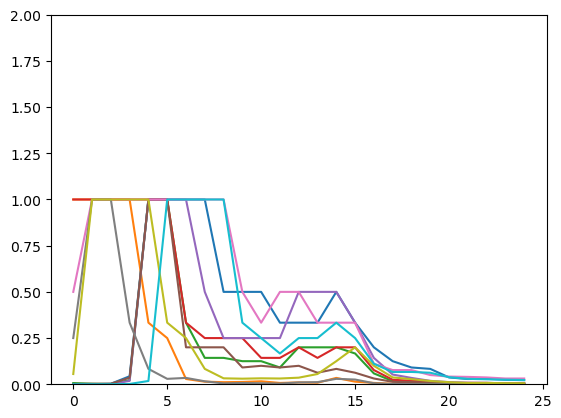

In [41]:
# Plot the results
plt.ylim([0,2])
for x in correct_token_rank_prompts:
    plt.plot(x)


In [42]:
def get_intervention_activations_diff(model, tokens, layer):
    model.reset_hooks()

    control_logits, control_cache = model.run_with_cache(tokens)
    control_projected = einsum('d_model, d_model d_vocab -> d_vocab', control_cache['ln_final.hook_normalized'][0,-1], model.W_U)
    print(model.to_str_tokens(control_logits[0,-1].argmax()), model.to_str_tokens(control_projected.argmax()))

    
    def FV_Hook(resid_pre, hook):
        resid_pre[:, -1, :] += FV
        return resid_pre

    model.add_hook(f"blocks.{layer}.hook_resid_pre", FV_Hook)

    logits, interv_cache = model.run_with_cache(tokens)

    interv_projected = einsum('d_model, d_model d_vocab -> d_vocab', interv_cache['ln_final.hook_normalized'][0,-1], model.W_U)
    print(model.to_str_tokens(logits[0,-1].argmax()), model.to_str_tokens(interv_projected.argmax()))
    
    diffs = []
    labels = []

    for i in control_cache.keys():
        if 'hook_attn_out' in i or 'hook_mlp_out' in i:
            diffs.append((control_cache[i][0,-1] - interv_cache[i][0,-1]).square().sum().sqrt().item())
            labels.append(i)

    return diffs, labels, interv_cache, logits


# Check Activation Differences

### Value of answer logit across different layers at last token pos

In [39]:
# Select which prompt
prompt_num = 1

# Get tokens from prompt and first layer of intervention
prompt_dict = zero_s_cases[prompt_num]
tks = prompt_dict['tokens']
answer_tk = prompt_dict['answer_tk']
layer = prompt_dict['layers'][0]

diffs, labels, cache, logits = get_intervention_activations_diff(model, tks, layer)

NameError: name 'zero_s_cases' is not defined

In [ ]:
plt.plot(diffs)
print([labels[x] for x in torch.tensor(diffs).topk(30).indices])

In [ ]:
logits.shape, projection_vocab_acc.shape, accumulated_residual.shape

In [36]:
#Project each layer residual at last token onto vocab space
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, return_labels=True, apply_ln=True
)


projection_vocab_acc = einsum("layer d_model, d_model d_vocab --> layer d_vocab", accumulated_residual[:,0,-1], model.W_U)


plt.plot(projection_vocab_acc[:,answers_tokens[prompt_num, -1]].cpu().numpy())

NameError: name 'cache' is not defined

In [ ]:
for i, x in enumerate(model.to_str_tokens(projection_vocab_acc.argmax(dim=1))):
    print(labels[i], i, "TOP TOKEN: " + x)

In [114]:
per_component_residual[:,-1,:].shape, model.W_U[:,answer_tk].shape

(torch.Size([65, 4096]), torch.Size([4096]))

['19_attn_out', '23_attn_out', '20_mlp_out', '30_mlp_out', '31_attn_out', '29_attn_out', '23_mlp_out', '25_mlp_out', '17_attn_out', '21_attn_out', '16_attn_out', '21_mlp_out', '28_mlp_out', '14_attn_out', '24_mlp_out', '18_attn_out', '15_attn_out', '22_mlp_out', '20_attn_out', '22_attn_out', '18_mlp_out', '28_attn_out', '30_attn_out', '26_attn_out', '27_attn_out', '24_attn_out', '4_attn_out', '14_mlp_out', '3_attn_out', '11_attn_out']
None


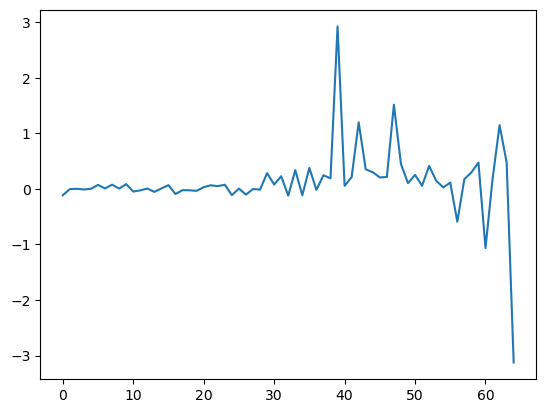

In [137]:
#Project each component contribution residual at last token onto vocab space
per_component_residual, decomp_labels = cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)


dots_vocab = einsum("layer d_model, d_model --> layer", per_component_residual[:,-1,:], model.W_U[:,answer_tk])


plt.plot(dots_vocab.cpu().numpy())

print(print([decomp_labels[x] for x in dots_vocab.cpu().topk(30).indices]))

### Look at top 1 token of projected residual stream and associated logit value

torch.Size([65, 6])
[['<s>', '<s>', '<s>', 'ions', 'ovis', '↔'], ['<s>', '<s>', '<s>', 'ions', 'ovis', '↔'], ['<s>', '<s>', '<s>', 'ions', '.', '↔'], ['<s>', '<s>', '<s>', 'idenote', 'ovis', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'ato', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'ato', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'FC', 'шов'], ['<s>', '<s>', '<s>', 'sierp', '(', 'шов'], ['<s>', '<s>', '<s>', 'sierp', '(', 'шов'], ['<s>', '<s>', '<s>', 'sierp', '(', '↔'], ['<s>', '<s>', '<s>', 'sierp', '(', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'pun', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'pair', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'sp', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'р', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'р', '↔'], ['<s>', '<s>', '<s>', 'sierp', 'fla', '↔'], ['<s>', '<s>', '<s>', 'sierp', ',', '↔'], ['<s>', '<s>', '<s>', 'sierp', '(', '↔'], ['<s>', '<s>', '<s>', 'sierp', '(', '↔'], ['<s>', '<s>', '<s>', 'sierp', '(', 'schließ'], ['<s>', '<s>', '<s>', 'sierp', '(', 'eper'], ['<s>', '<s>', '<s>

<Axes: >

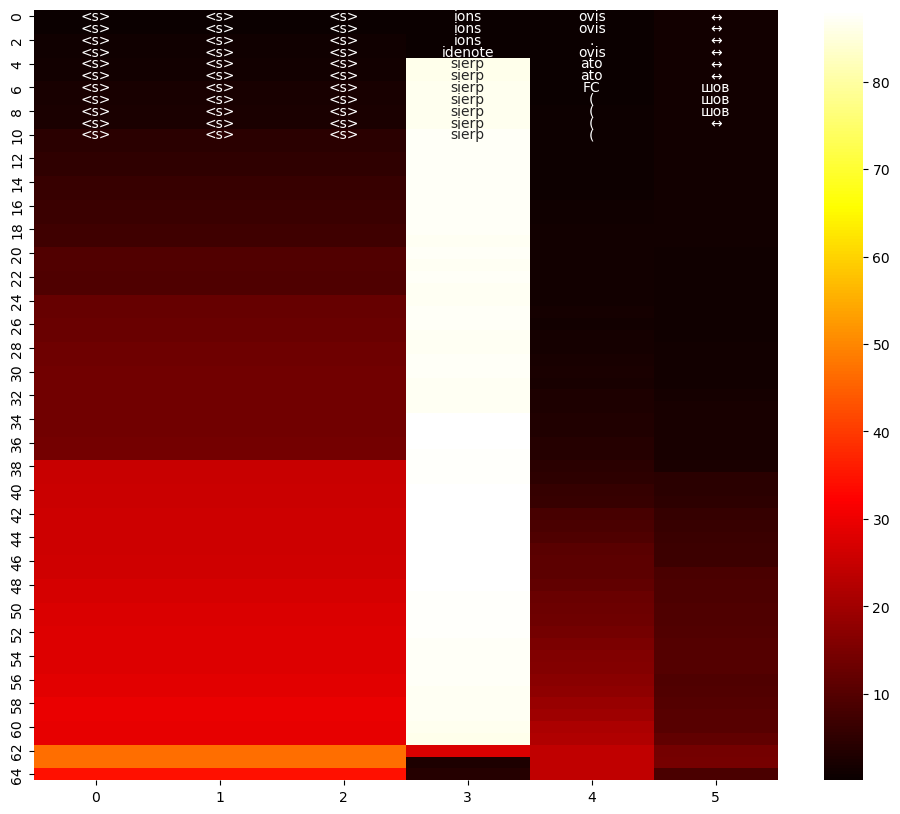

In [155]:
from matplotlib import pyplot as plt
import numpy as np


# Returns the accumulated residual stream at each layer/sub-layer and apply_ln applies final layer norm
accumulated_residual, labels = cache.accumulated_resid(
    layer=-1, incl_mid=True, apply_ln=True, return_labels=True
)

# Project each layer and each position onto vocab space
projection_vocab = einsum("layer pos d_model, d_model d_vocab --> layer pos d_vocab", accumulated_residual[:,0,:,:], model.W_U)

# Get maximum logit at each layer
max_logit, max_index = projection_vocab.max(-1)

print(max_index.shape)

# Convert max index tokens to strings

print(top_preds)
# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(max_logit.cpu(), annot=top_preds, fmt = '', cmap='hot')

# Get the specific components that contribute most

In [138]:
for i, x in enumerate(dots_vocab.topk(10).indices):
    print(i, decomp_labels[x], x.item())

0 19_attn_out 39
1 23_attn_out 47
2 20_mlp_out 42
3 30_mlp_out 62
4 31_attn_out 63
5 29_attn_out 59
6 23_mlp_out 48
7 25_mlp_out 52
8 17_attn_out 35
9 21_attn_out 43


In [158]:
# Get head residuals
per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=-1, apply_ln=True, return_labels=True
)
print(per_head_residual.shape)

# Get the dot product of these with correct answer token
per_head_dot = einsum("head d_model, d_model -> head", per_head_residual[:,0,:], model.W_U[:, answer_tk])

# Store top 10 heads
top_heads = per_head_dot.topk(10).indices

# Rearrange for plotting\
per_head_dot = einops.rearrange(
    per_head_dot,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_dot,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
)

torch.Size([1024, 1, 4096])


ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


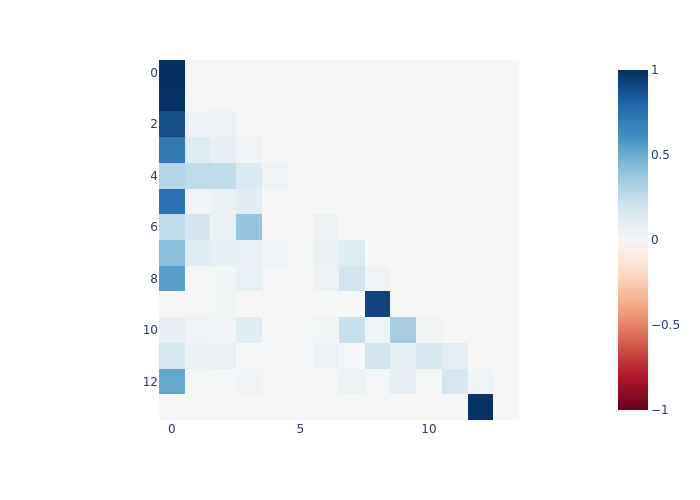

Layer 15, Head 5
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


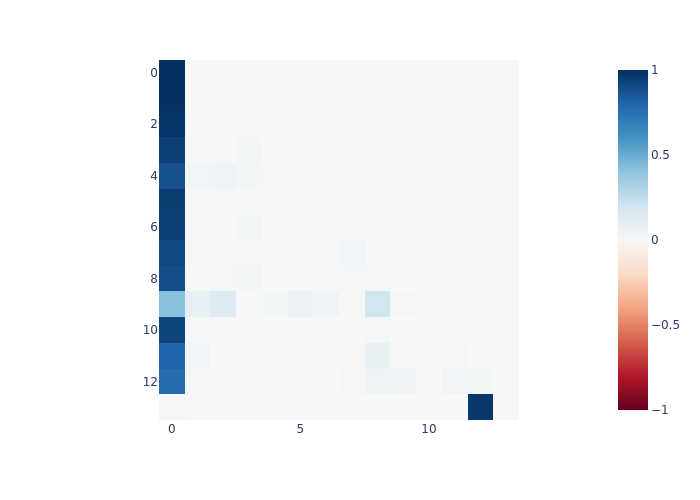

Layer 13, Head 2
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


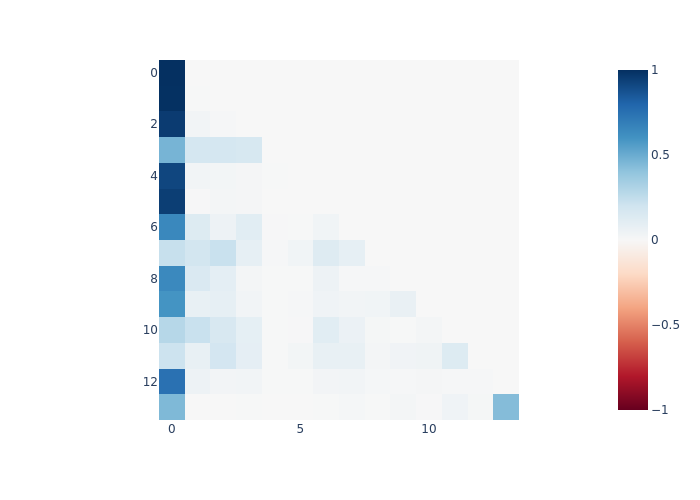

Layer 21, Head 0
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


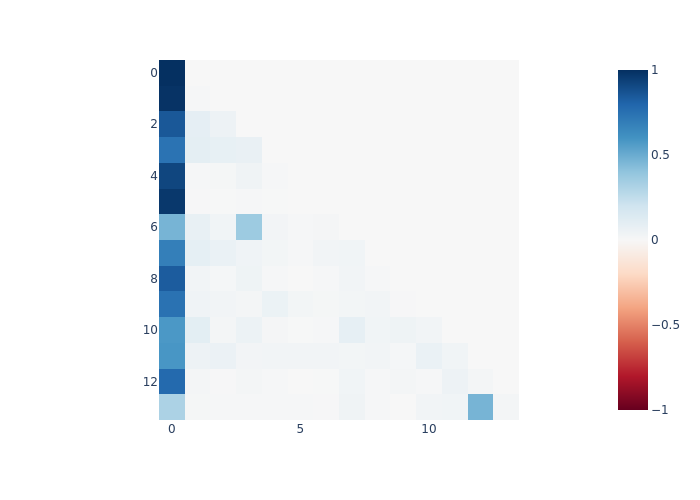

Layer 20, Head 11
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


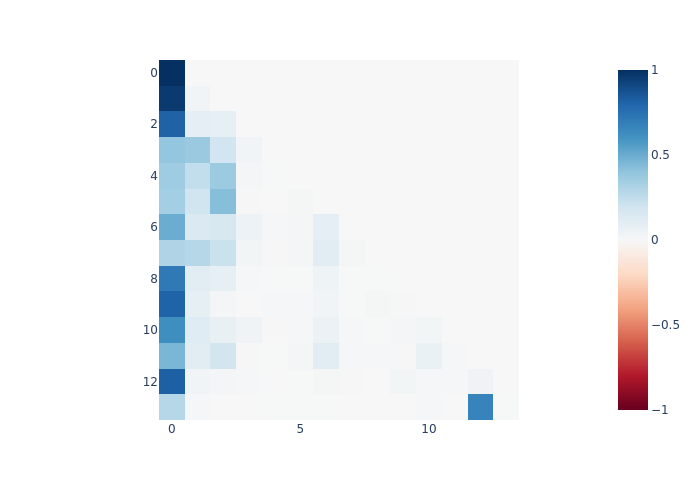

Layer 17, Head 1
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


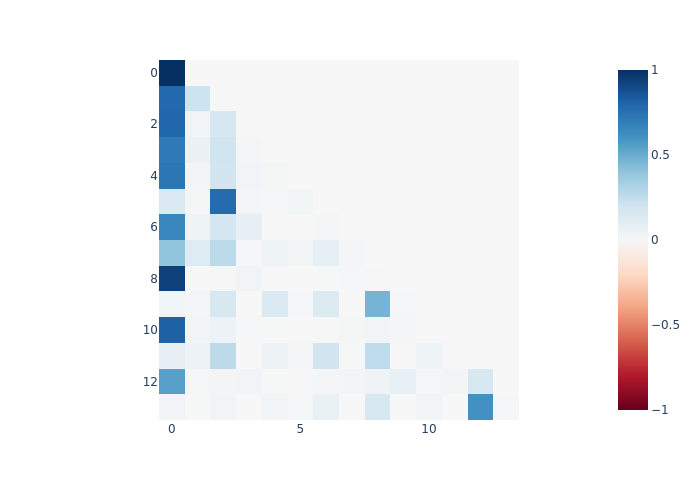

Layer 17, Head 2
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


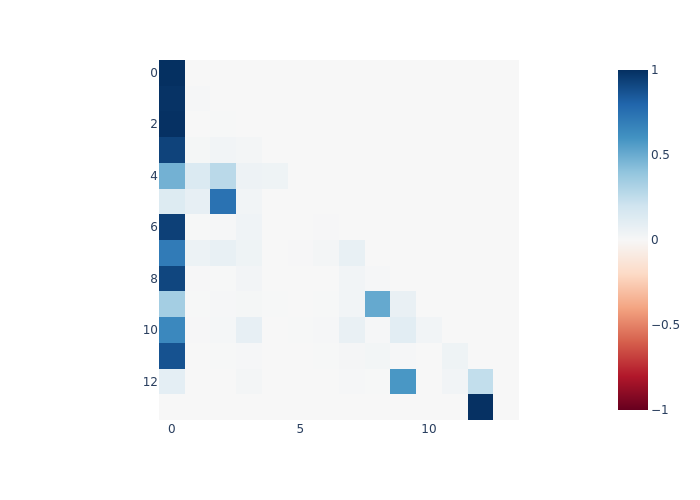

Layer 13, Head 12
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


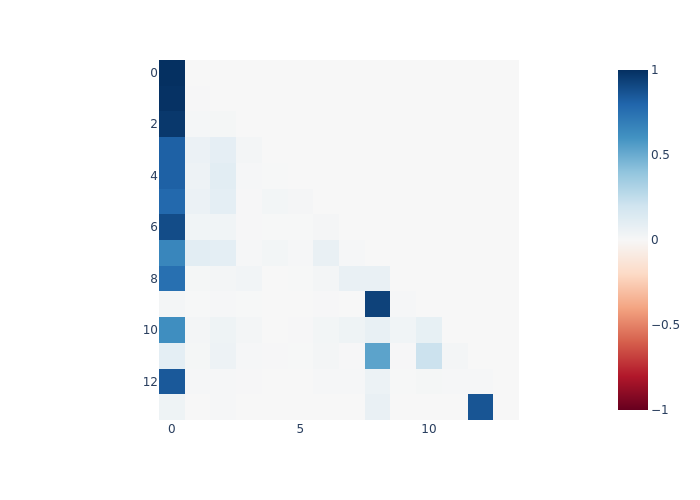

Layer 18, Head 1
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


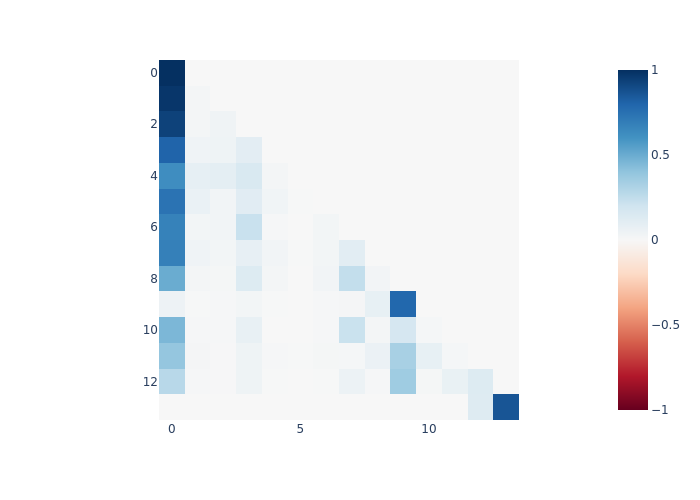

Layer 12, Head 15
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


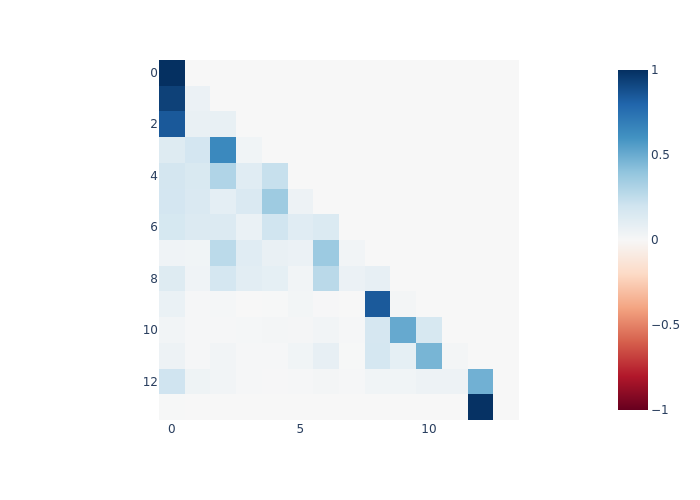

Layer 13, Head 3
['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']


In [ ]:
for i in range(10):
    layer = top_heads[i]//model.cfg.n_heads
    index = top_heads[i]%model.cfg.n_heads
    imshow(cache[f'blocks.{layer}.attn.hook_pattern'][prompt_num][index])
    labels={"x": "Head", "y": "Layer"}
    print(f"Layer {layer}, Head {index}")
    print(model.to_str_tokens(tokens[prompt_num]))

# Looking at the top MLPs

In [ ]:
# Print the prompt
print(model.to_str_tokens(tokens[prompt_num]))

# Taken from figure
top_mlp_layers = [16, 20, 21]

# Iterate over top contributing MLP Layers
for layer in top_mlp_layers:
    # For each layer, get the top contributing neurons
    neuron_contr = einsum('d_mlp d_model, d_model -> d_mlp', model.blocks[layer].mlp.W_out.detach(), model.W_U[:,answer_tokens.flatten()[prompt_num]])
    top_neurons = neuron_contr.topk(10).indices

    # Project the top contributing neurons onto the vocab space
    projected_val = einsum('top d_model, d_model d_vocab-> top d_vocab', model.blocks[layer].mlp.W_out[top_neurons, :].detach(), model.W_U)

    print(f"__________{layer}__________")
    for x in range(10):
        # Print the vocab projection of the top contributing neurons
        print("Neuron: ", top_neurons[x].item(), "Contribution: ",neuron_contr[top_neurons[x]].item())
        print(model.to_str_tokens(projected_val[x, :].topk(10).indices))
              

['<|endoftext|>', 'incre', 'ase', ':', 'dec', 're', 'ase', ',', ' good', ':', 'bad', ',', ' fast', ':']
__________16__________
Neuron:  1643 Contribution:  3.348935842514038
[' inability', ' insufficient', 'failed', ' ineffective', ' failed', ' failures', ' unable', ' lackluster', ' lacks', ' lose']
Neuron:  591 Contribution:  2.997021436691284
['National', 'Ent', 'Strong', 'Individual', 'Member', 'Hall', 'Elect', 'Church', 'Trans', 'Tax']
Neuron:  2924 Contribution:  2.8960635662078857
[' negatively', 'appropriately', ' cautiously', ' differently', ' creatively', ' responsibly', ' objectively', ' wisely', ' positively', ' offensively']
Neuron:  486 Contribution:  2.8068737983703613
[' ardu', ' tedious', ' painstaking', ' costly', 'intensive', 'expensive', ' labor', 'cost', ' exhausting', 'requires']
Neuron:  3524 Contribution:  2.6780171394348145
['_', '@', 'kid', 'boss', 'Mex', 'Mc', 'oft', '1992', 'Dr', '1986']
Neuron:  3950 Contribution:  2.586076498031616
['prem', 'dec', 'positive

# Looking at Function Vectors Causal Impact

In [ ]:
# Zero shot prompt
prompt = "increase:"

# Retrieve Function Vectors
FV = np.load("Antonym_FV.npy", allow_pickle=True)

# Find the layer of most impact


In [ ]:
# 